# Animal Future data analysis

Notebook for the analysis of the analysis of the survey data collected in the scope of the Animal Future project for Portugal. 

**Objective**: understand which are the indicators that influenced past adoption of SBP. The goal is to replace the education level as proxy indicator for the risk aversion of farmers.

In [633]:
import pandas as pd
import numpy as np
import math
import os

In [634]:
# For plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [635]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Data ingestion

### Area use data

In [636]:
path_area_data = '../survey_data/43_Areas_POR_DualPurpose.xlsx'
columns_to_fetch = ['FARM_ID', 'AREA_ID', 'Surface']
area_data_original = pd.read_excel(path_area_data, sheet_name='Main', index_col=0, usecols=columns_to_fetch)
area_data_original = area_data_original.drop('PT00')

Get label:
* 1 if the farm has any sown permanent pasture
* 0 otherwise

In [637]:
area_data_SBP_or_not = area_data_original['AREA_ID'].str.contains('Sown permanent pasture')
area_data_SBP_or_not = area_data_SBP_or_not.groupby('FARM_ID').any()

area_data = pd.DataFrame()
area_data['AdoptedSBP'] = area_data_SBP_or_not.astype(int)

In [638]:
area_data.head()

,AdoptedSBP
FARM_ID,
PT01,0
PT02,0
PT03,1
PT04,1
PT05,0


Get total pasture area

In [639]:
area_data_original = area_data_original[area_data_original['AREA_ID'].str.contains('pasture')]
area_data['PastureSurface'] = area_data_original.groupby('FARM_ID')['Surface'].sum()

area_data.head()

,AdoptedSBP,PastureSurface
FARM_ID,,
PT01,0,60.90
PT02,0,364.00
PT03,1,3450.44
PT04,1,160.40
PT05,0,457.37


### Livestock data

In [640]:
path_animal_data = '../survey_data/43_AnimalCategories_POR_DualPurpose.xlsx'
columns_to_fetch = ['FARM_ID', 'LivestockType', 'AverageNumber']
animal_data_original = pd.read_excel(path_animal_data, sheet_name='Main', index_col=0, usecols=columns_to_fetch)
animal_data_original = animal_data_original.drop('PT00') # Drop farm 00, not relevant for the analysis

Get percentage of cattle for each farm

In [641]:
total_animals = animal_data_original.groupby('FARM_ID')['AverageNumber'].sum().rename('AverageAnimals')

total_animals_per_type = animal_data_original.groupby(['FARM_ID', 'LivestockType'], as_index=True).sum()
total_cattle = total_animals_per_type.query('LivestockType == "Cattle"').rename(columns={'AverageNumber': 'AverageCattle'})

total_animal_cattle = pd.merge(total_animals, total_cattle, on='FARM_ID', how='outer')
total_animal_cattle = total_animal_cattle.fillna(0)

In [642]:
animal_data = pd.DataFrame()
animal_data['CattlePercentage'] = total_animal_cattle['AverageCattle'] / total_animal_cattle['AverageAnimals']

animal_data.head()

,CattlePercentage
FARM_ID,
PT01,0.000000
PT02,0.000000
PT03,1.000000
PT04,1.000000
PT05,0.410191


### Location data

**Note**: 'PT35' had a white space in the excel file after the name that made it disappear when merging the datasets.

In [643]:
path_location_data = '../survey_data/Farms_Location.xls'
columns_to_fetch = ['FARM_ID', 'Distrito', 'Concelho']
# Imported without FARM_ID as index since need to be fixed before
location_data = pd.read_excel(path_location_data, usecols=columns_to_fetch) 

location_data.head()

,FARM_ID,Distrito,Concelho
0,PT1,Portalegre,Elvas
1,PT2,Setúbal,Grândola
2,PT3,Santarém,Benavente
3,PT4,Setúbal,Montijo
4,PT5,Évora,Montemor


In [644]:
# Add a 0 in the FARM_ID to be consistent with the other databases
num_idx = 2
for idx in range(len(location_data['FARM_ID'])):
    if len(location_data['FARM_ID'][idx]) == 3:
        location_data['FARM_ID'][idx] = location_data['FARM_ID'][idx][:num_idx] + '0' + location_data['FARM_ID'][idx][num_idx:]

In [645]:
location_data = location_data.set_index('FARM_ID')

In [646]:
location_data.head()

,Distrito,Concelho
FARM_ID,,
PT01,Portalegre,Elvas
PT02,Setúbal,Grândola
PT03,Santarém,Benavente
PT04,Setúbal,Montijo
PT05,Évora,Montemor


### Farms general data

In [647]:
path_general_data = '../survey_data/31_FarmsGeneral_DualPurpose.xlsx'
columns_to_fetch = ['FARM_ID', 'OwnLand', 'RentedLand', 'LegalForm','FarmerSince']
general_data_original = pd.read_excel(path_general_data, index_col=0, usecols=columns_to_fetch)
general_data_original = general_data_original.drop('PT00')

Get percentage of rented land over total one

In [648]:
general_data = general_data_original[['FarmerSince']]
general_data['PercentRentedLand'] = general_data_original['RentedLand'] / (general_data_original['OwnLand'] + general_data_original['RentedLand'])

C:\Users\giaco\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Tranform LegalForm it into a binary category, "Associated" if part of a cooperative/association (including ENI) and "Individual" if individual

In [649]:
mapping = {'Cooperativa Social': "Associated", 'ENI': "Associated", 'Sociedade Agrícola': "Associated", 'Individual': 'Individual'}
general_data['LegalForm'] = general_data_original.loc[:, 'LegalForm'].replace(mapping)

C:\Users\giaco\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [650]:
general_data.head()

,FarmerSince,PercentRentedLand,LegalForm
FARM_ID,,,
PT02,29,0.0,Individual
PT13,11,0.0,Associated
PT15,11,1.0,Associated
PT16,3,1.0,Individual
PT17,10,1.0,Associated


### Education data

In [651]:
path_education_data = '../survey_data/31_Social_Education_DualPurpose.xlsx'
columns_to_fetch = ['FARM_ID', 'HighestEducationalDegree', 'HighestAgriculturalEducationalDegree']
education_data = pd.read_excel(path_education_data, index_col=0, usecols=columns_to_fetch)
education_data = education_data.drop('PT00')
education_data['HighestAgriculturalEducationalDegree'] = education_data['HighestAgriculturalEducationalDegree'].fillna('None')

education_data.head()

,HighestEducationalDegree,HighestAgriculturalEducationalDegree
FARM_ID,,
PT02,Undergraduate,Undergraduate
PT13,Undergraduate,Undergraduate
PT15,Undergraduate,Undergraduate
PT16,Undergraduate,Undergraduate
PT17,Undergraduate,None


### Succession data

In [652]:
path_succession_data = '../survey_data/31_Social_Succession_DualPurpose.xlsx'
columns_to_fetch = ['FARM_ID', 'ExpectationFarmSuccession']
succession_data_original = pd.read_excel(path_succession_data, index_col=0, usecols=columns_to_fetch)
succession_data_original = succession_data_original.drop('PT00')

In [653]:
succession_data_original['ExpectationFarmSuccession'].value_counts()

2    20
1     9
5     1
Name: ExpectationFarmSuccession, dtype: int64

Since in the data we have just farmers that either expect a family succession or not (and one answer as "other"), we transform this feature in a binary one, either if family succession is expected or not

In [654]:
succession_data=pd.DataFrame()
mapping = {1: "No", 2: "Yes", 5: "No"}
succession_data['ExpectationFamilySuccession'] = succession_data_original['ExpectationFarmSuccession'].replace(mapping)

succession_data.head()

,ExpectationFamilySuccession
FARM_ID,
PT02,Yes
PT13,Yes
PT15,Yes
PT16,Yes
PT17,Yes


In [655]:
## Old version to have more categories

#mapping = {1: 'NoExpectation', 2: 'FamilyInheritance', 5: 'NoExpectation'}
## Since we have only one instance that answered 5 (that would be 'Other'), we make it fall in the category NoExpectation
#succession_data['ExpectationFarmSuccession'] = succession_data_original['ExpectationFarmSuccession'].replace(mapping)

#succession_data.head()

# Analysis on data for 30 farmers

In [656]:
import functools

In [657]:
farms_dataframes = [area_data, animal_data, location_data, general_data, education_data, succession_data]
farms30 = functools.reduce(lambda left, right: pd.merge(left, right, on='FARM_ID'), farms_dataframes)

farms30.head()

,AdoptedSBP,PastureSurface,CattlePercentage,Distrito,Concelho,FarmerSince,PercentRentedLand,LegalForm,HighestEducationalDegree,HighestAgriculturalEducationalDegree,ExpectationFamilySuccession
FARM_ID,,,,,,,,,,,
PT02,0,364.00,0.0,Setúbal,Grândola,29,0.0,Individual,Undergraduate,Undergraduate,Yes
PT13,1,542.58,1.0,Portalegre,Avis,11,0.0,Associated,Undergraduate,Undergraduate,Yes
PT15,1,262.70,1.0,Portalegre,Monforte,11,1.0,Associated,Undergraduate,Undergraduate,Yes
PT16,0,23.00,1.0,Évora,Évora,3,1.0,Individual,Undergraduate,Undergraduate,Yes
PT17,1,250.00,1.0,Évora,Montemor,10,1.0,Associated,Undergraduate,None,Yes


## Data exploration

In [658]:
farms30.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, PT02 to PT43
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   AdoptedSBP                            30 non-null     int32  
 1   PastureSurface                        30 non-null     float64
 2   CattlePercentage                      30 non-null     float64
 3   Distrito                              30 non-null     object 
 4   Concelho                              30 non-null     object 
 5   FarmerSince                           30 non-null     int64  
 6   PercentRentedLand                     30 non-null     float64
 7   LegalForm                             30 non-null     object 
 8   HighestEducationalDegree              30 non-null     object 
 9   HighestAgriculturalEducationalDegree  30 non-null     object 
 10  ExpectationFamilySuccession           30 non-null     object 
dtypes: float64(3), int32(

### Numerical attributes

In [659]:
numerical_attributes = ['AdoptedSBP', 'PastureSurface', 'CattlePercentage', 'FarmerSince', 'PercentRentedLand']
farms30_num = farms30[numerical_attributes]

In [660]:
farms30_num.describe()

,AdoptedSBP,PastureSurface,CattlePercentage,FarmerSince,PercentRentedLand
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.566667,509.447667,0.810436,16.033333,0.248616
std,0.504007,618.480397,0.346573,11.505571,0.411126
min,0.000000,23.000000,0.000000,1.000000,0.000000
25%,0.000000,141.250000,0.739726,8.000000,0.000000
50%,1.000000,316.000000,1.000000,11.000000,0.000000
75%,1.000000,424.920000,1.000000,25.750000,0.371753
max,1.000000,2500.000000,1.000000,40.000000,1.000000


Saving figure Numerical Attributes_Histograms


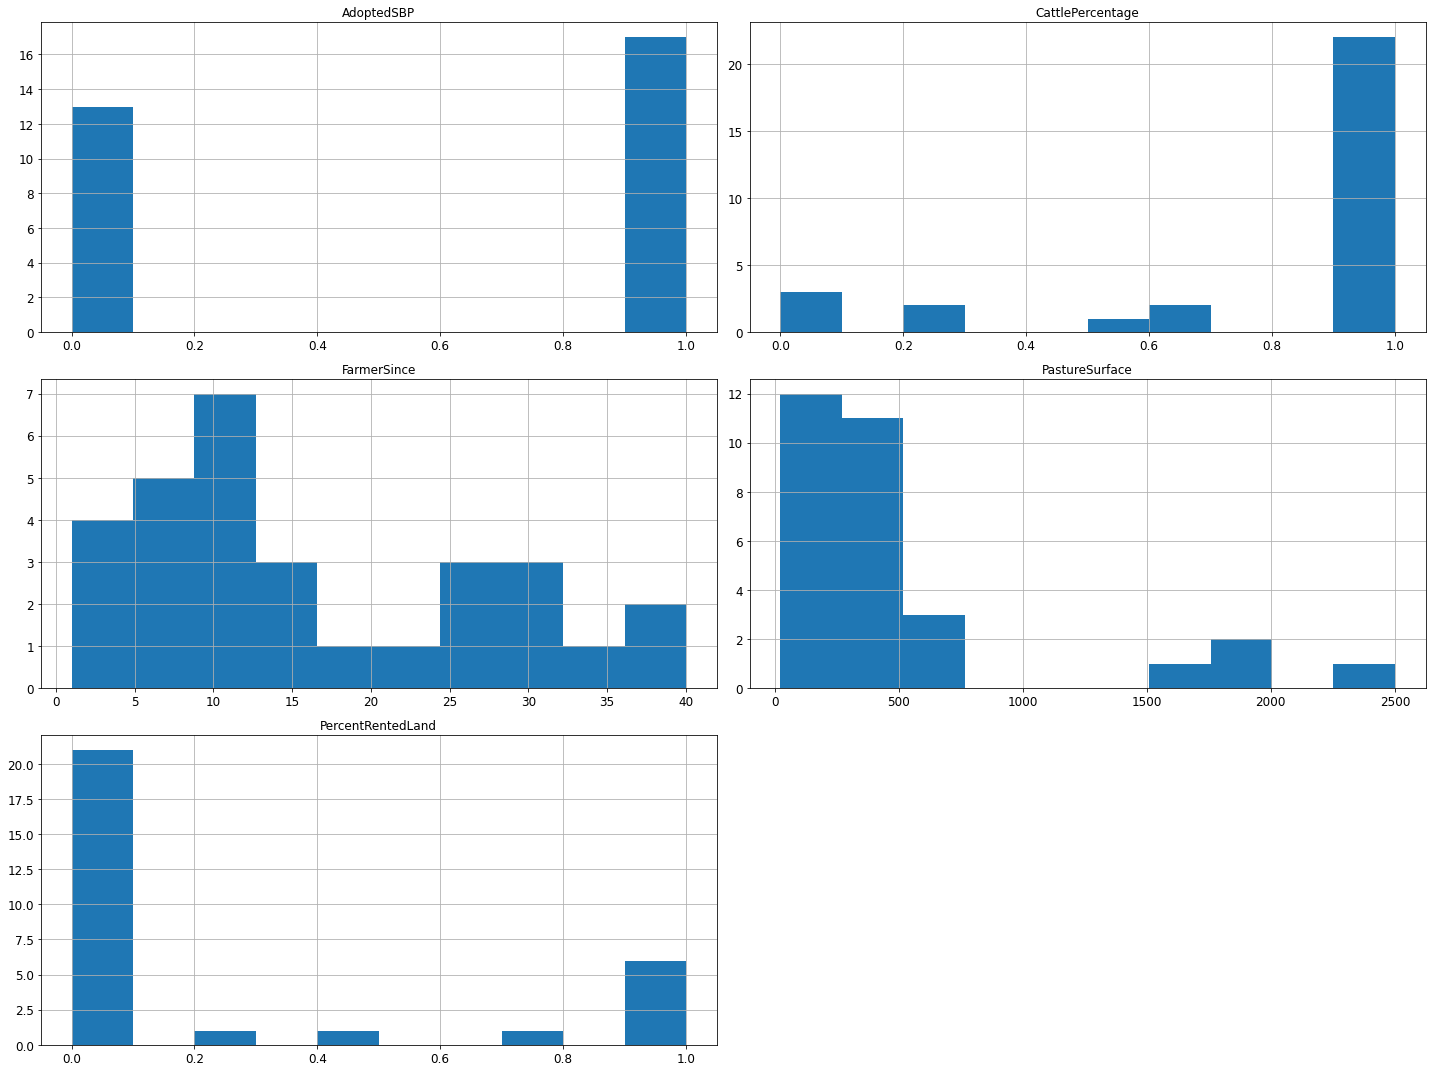

In [661]:
farms30_num.hist(figsize=(20,15))
save_fig('Numerical Attributes_Histograms')

#### Correlations

Pearson's correlation

corr_matrix = farms30_num.corr()
corr_matrix

corr_matrix['AdoptedSBP'].sort_values(ascending=False)

from pandas.plotting import scatter_matrix

scatter_matrix(farms30[['AdoptedSBP', 'PastureSurface', 'ExpectationFamilySuccession', 'PercentRentedLand']], figsize=(12, 12))
save_fig('Numerical Attributes_Correlation Matrix')

Person's with SciPy

from scipy.stats import pearsonr
for (columnName, columnData) in farms30_num.iteritems():
    coef, p = pearsonr(columnData, farms30_num['AdoptedSBP'])
    print(columnName, coef, p)

Spearman's correlation

In [662]:
from scipy.stats import spearmanr
for (columnName, columnData) in farms30_num.iteritems():
    coef, p = spearmanr(columnData, farms30_num['AdoptedSBP'])
    print(columnName, coef, p)

AdoptedSBP 1.0 0.0
PastureSurface 0.13600431549464917 0.47361260369725755
CattlePercentage -0.049925873501914346 0.7933222226556211
FarmerSince 0.015572826296638708 0.9349041243272547
PercentRentedLand -0.21886442817943424 0.24524074278318292


Kendall's correlation

from scipy.stats import kendalltau
for (columnName, columnData) in farms30_num.iteritems():
    coef, p = kendalltau(columnData, farms30_num['AdoptedSBP'])
    print(columnName, coef, p)

#### CattlePercentage focus

In [663]:
farms30_cowbins = pd.DataFrame()
farms30_cowbins['AdoptedSBP'] = farms30['AdoptedSBP'].copy()
farms30_cowbins['CattlePercentage'] = pd.cut(farms30['CattlePercentage'],
                                             bins=[-np.inf,0.33,0.66,np.inf],
                                             labels=[1,2,3])

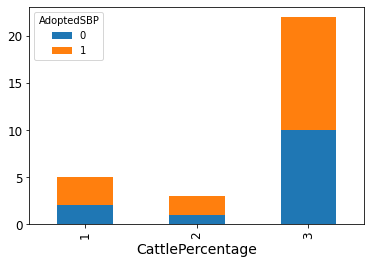

In [664]:
fig = farms30_cowbins.groupby('CattlePercentage')['AdoptedSBP'].value_counts().unstack().plot(kind='bar', stacked=True)

It looks like there is no evidence of the percentage of cattle influencing adoption

### Categorical attributes

In [665]:
categorical_attributes = ['Distrito', 'Concelho', 'LegalForm', 'HighestEducationalDegree', 
                          'HighestAgriculturalEducationalDegree', 'ExpectationFamilySuccession']

In [666]:
for cat_attr in categorical_attributes:
    print(farms30[cat_attr].value_counts())
    print("")

Évora         13
Beja           8
Setúbal        4
Portalegre     4
Santarém       1
Name: Distrito, dtype: int64

Montemor                6
Évora                   5
Beja                    2
Ferreira do Alentejo    1
Arronches               1
Avis                    1
Arraiolos               1
Ourique                 1
Elvas                   1
Alcácer do Sal          1
Monforte                1
Portel                  1
Aljustrel               1
Alvito                  1
Castro Verde            1
Coruche                 1
Grândola                1
Serpa                   1
Montijo                 1
Santiago do Cacém       1
Name: Concelho, dtype: int64

Associated    22
Individual     8
Name: LegalForm, dtype: int64

Undergraduate    14
Graduate         13
Secondary         2
Primary           1
Name: HighestEducationalDegree, dtype: int64

Undergraduate    13
Graduate         11
None              6
Name: HighestAgriculturalEducationalDegree, dtype: int64

Yes    20
No     10
Name: 

Saving figure Categorical Attributes_Stacked Histograms


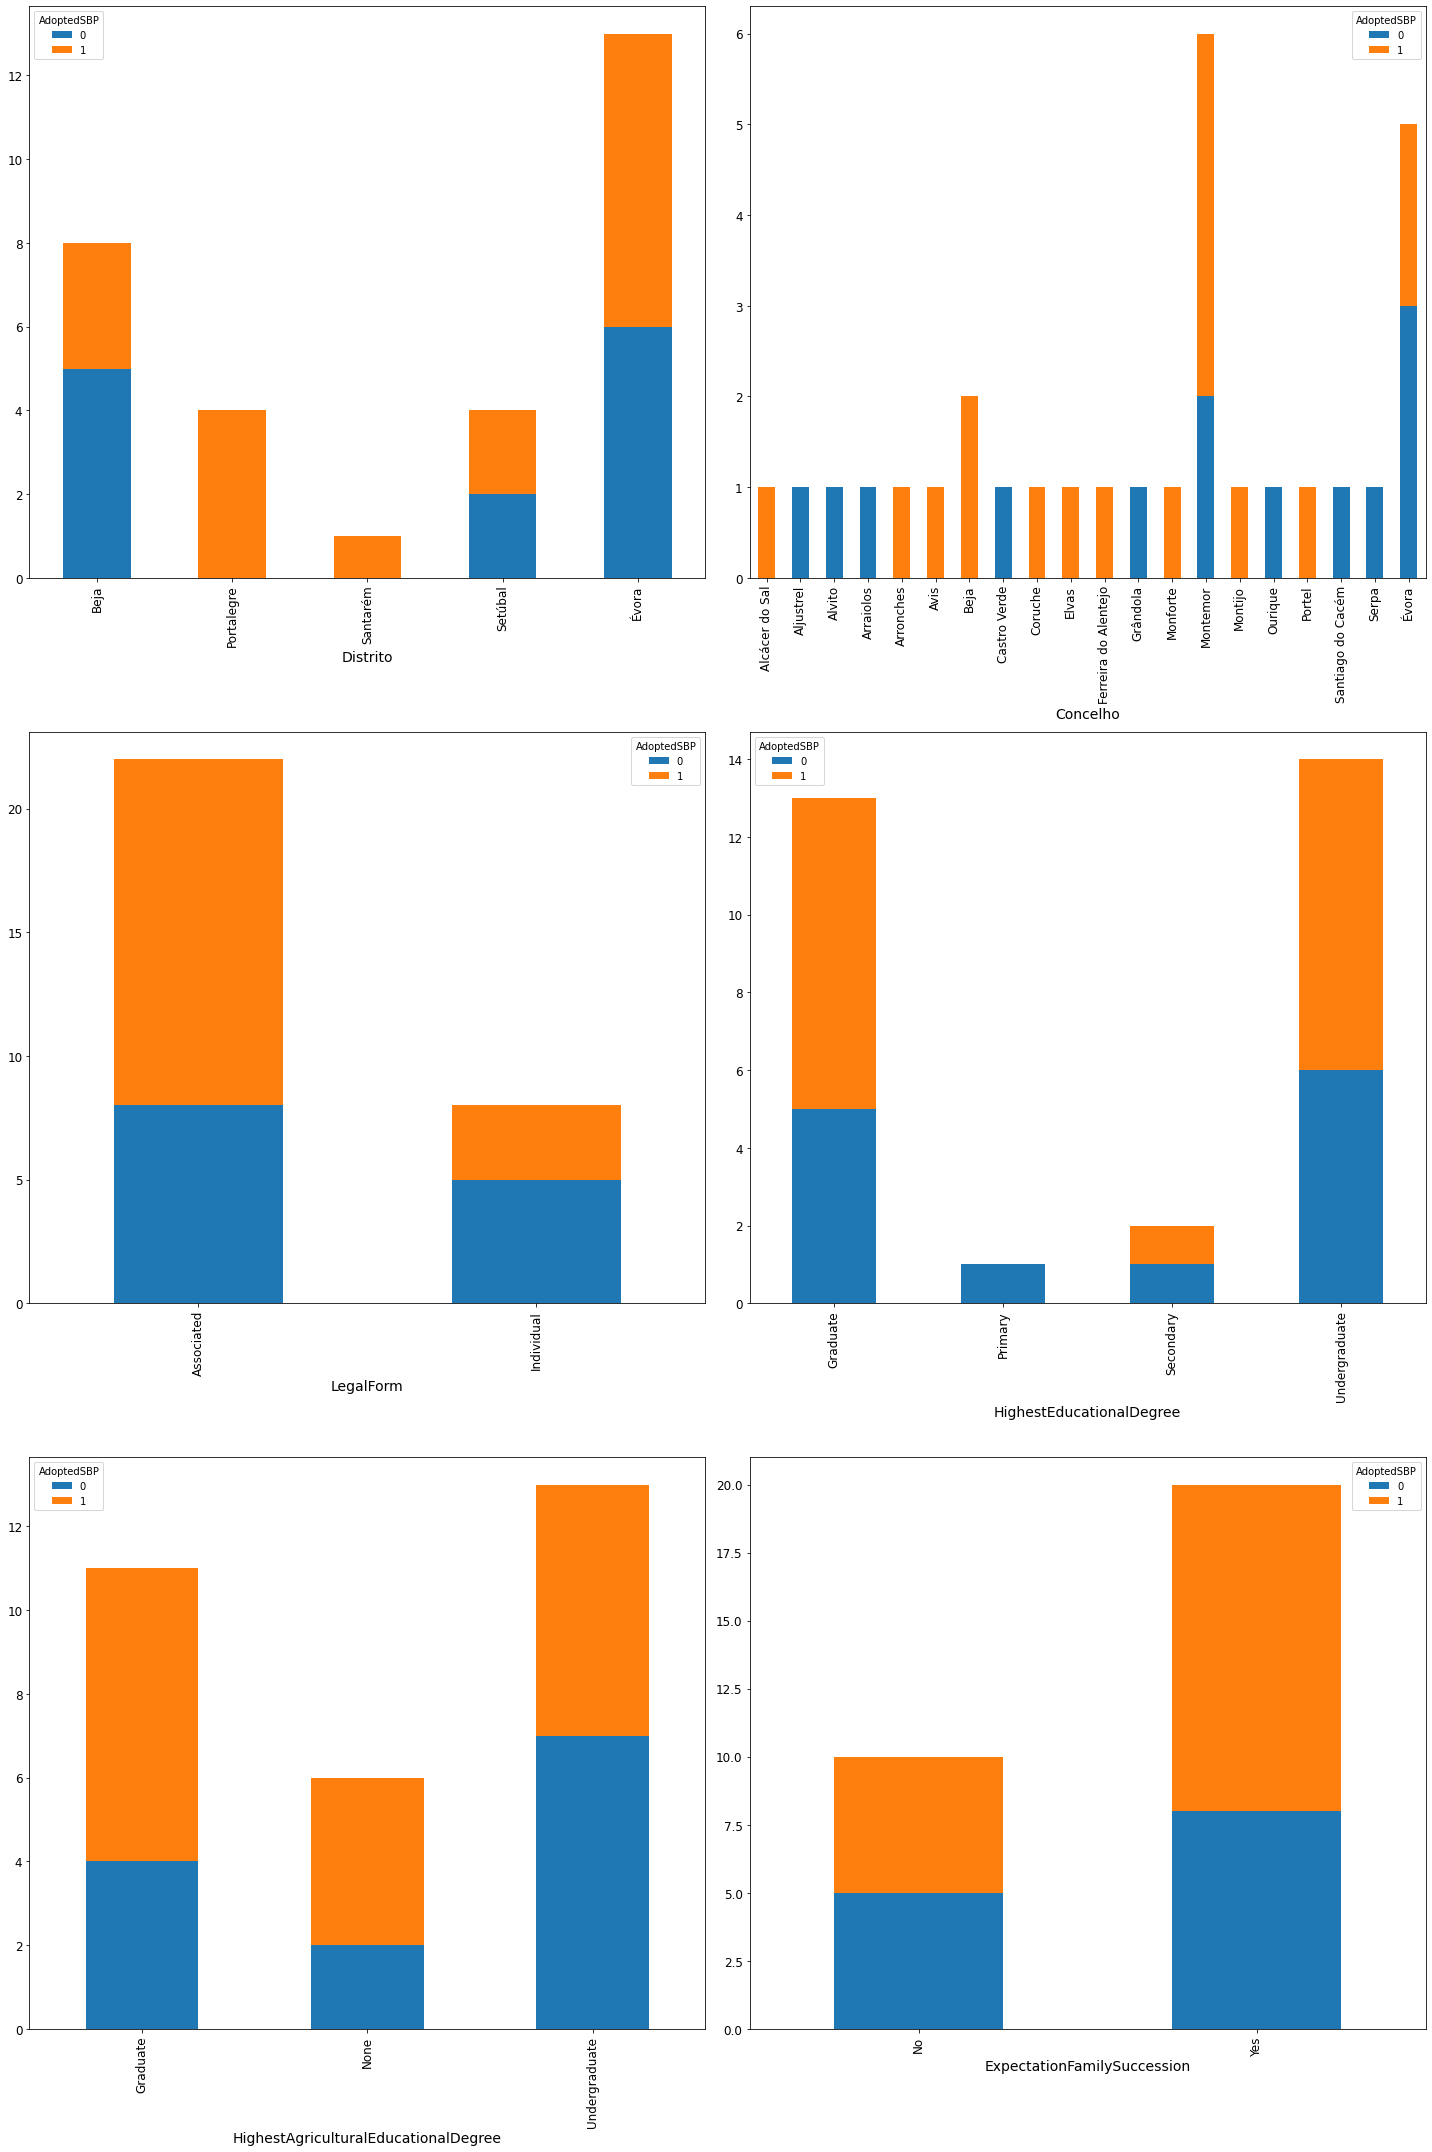

In [667]:
fig, axes = plt.subplots(math.ceil(len(categorical_attributes)/2), ncols=2, figsize=(20, 30))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)
axes = axes.flatten()
i = 0

for cat_attr in categorical_attributes:
    hist = farms30.groupby(cat_attr)['AdoptedSBP'].value_counts().unstack().plot(ax=axes[i], kind='bar', stacked=True)
    i += 1
    
save_fig('Categorical Attributes_Stacked Histograms')

### Person's Chi-squared test for categorical features

#### scikit-learn implementation
**NOTE**: results different than doing it manually with excel, for the right version check implementation below with Scipy

In [668]:
farms_categoricals = farms30[categorical_attributes]
farms_categoricals.head()

,Distrito,Concelho,LegalForm,HighestEducationalDegree,HighestAgriculturalEducationalDegree,ExpectationFamilySuccession
FARM_ID,,,,,,
PT02,Setúbal,Grândola,Individual,Undergraduate,Undergraduate,Yes
PT13,Portalegre,Avis,Associated,Undergraduate,Undergraduate,Yes
PT15,Portalegre,Monforte,Associated,Undergraduate,Undergraduate,Yes
PT16,Évora,Évora,Individual,Undergraduate,Undergraduate,Yes
PT17,Évora,Montemor,Associated,Undergraduate,None,Yes


In [669]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

farms_labels = farms30['AdoptedSBP'].copy()

In [670]:
oe = OrdinalEncoder()
farms_categoricals_enc = oe.fit_transform(farms_categoricals)

In [671]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from matplotlib import pyplot

In [672]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(farms_categoricals_enc, farms_labels)
for i in range(len(fs.scores_)):
    print('Feature {0:40}: {1:<40} {2:<40}'.format(categorical_attributes[i],fs.scores_[i], fs.pvalues_[i]))

Feature Distrito                                : 0.006464124111183026                     0.9359193044109877                      
Feature Concelho                                : 1.4533480134806724                       0.2279914942924309                      
Feature LegalForm                               : 1.19683257918552                         0.2739556639095606                      
Feature HighestEducationalDegree                : 0.034754982189275                        0.8521100134498879                      
Feature HighestAgriculturalEducationalDegree    : 0.5791855203619907                       0.4466317481305161                      
Feature ExpectationFamilySuccession             : 0.0904977375565614                       0.7635453365378564                      


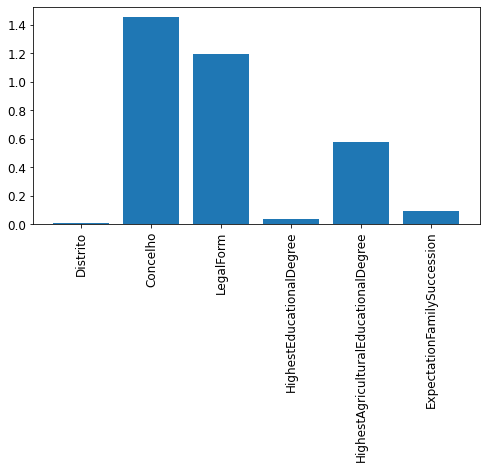

In [673]:
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.xticks([0, 1, 2, 3, 4, 5], categorical_attributes, rotation='vertical')
fig = plt.gcf()
fig.set_size_inches(8, 4)
pyplot.show()

**Why such a high result for Concelho?** 
If we'd have 24 different Concelhos, 1 for each instance, and 12 adopters and 12 not, the expected value - with independent categories - for each cell would be: (1*12)/24 = 0.5. But 0.5 is not possible as label, it will always be 0 or 1 so we will have a high value of Chi2.

#### SciPy implementation 
(same results as with Excel)

In [674]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [675]:
pd.crosstab(farms_labels,
            farms_categoricals['LegalForm'],  
            margins = False)

LegalForm,Associated,Individual
AdoptedSBP,,
0,8,5
1,14,3


In [676]:
def chi2_test(attribute):
    contingency_tab= pd.crosstab(farms_labels,
                                farms_categoricals[attribute],  
                                margins = False)
    stat, p, dof, expected = chi2_contingency(contingency_tab)
    # interpret p-value
    alpha = 0.05 # Significance value
    print('significance=%.3f, p=%.3f' % (alpha, p))
    print('chi2:', stat)
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    return p

In [677]:
p_values = []
for cat in categorical_attributes:
    print(cat)
    p_values.append(chi2_test(cat))
    print('')

Distrito
significance=0.050, p=0.274
chi2: 5.134876435781413
Independent (fail to reject H0)

Concelho
significance=0.050, p=0.414
chi2: 19.683257918552037
Independent (fail to reject H0)

LegalForm
significance=0.050, p=0.389
chi2: 0.7412073220896748
Independent (fail to reject H0)

HighestEducationalDegree
significance=0.050, p=0.689
chi2: 1.47083685545224
Independent (fail to reject H0)

HighestAgriculturalEducationalDegree
significance=0.050, p=0.592
chi2: 1.0470524950162956
Independent (fail to reject H0)

ExpectationFamilySuccession
significance=0.050, p=0.896
chi2: 0.016968325791855206
Independent (fail to reject H0)



In [678]:
p_values

[0.27373618477171296,
 0.4138592101306334,
 0.38927440409504843,
 0.6890173384117319,
 0.5924278132880957,
 0.8963587269811479]

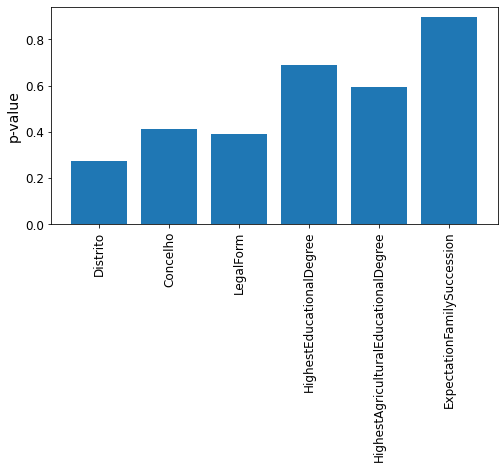

Saving figure p-values of adoption and categ. attribute are independent


<Figure size 432x288 with 0 Axes>

In [679]:
pyplot.bar([i for i in range(len(p_values))], p_values)
pyplot.xticks([0, 1, 2, 3, 4, 5], categorical_attributes, rotation='vertical')
pyplot.ylabel('p-value')
fig = plt.gcf()
fig.set_size_inches(8, 4)
pyplot.show()
save_fig('p-values of adoption and categ. attribute are independent')

**Result**: impossible to reject all null-hypothesis of independece

## Logistic regression

Drop unusable data

In [680]:
farms30_selected = farms30.drop('Concelho', axis=1) # Too many with too few instances each. Distrito is better
farms30_selected = farms30.drop('HighestAgriculturalEducationalDegree', axis=1) # Redundant with HighestEducationalDegree

### Split the data

**Possible improvement**: performe stratified sampling

In [681]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(farms30_selected, test_size=0.2, random_state=42)

### Data preparation

In [682]:
farms = train_set.drop('AdoptedSBP', axis=1)
farms_labels = train_set['AdoptedSBP'].copy()

#### Categorical attributes

Ordinal econding for HighestEducationalDegree

In [683]:
farms_ordinal_attributes = ['HighestEducationalDegree']
farms_ordinal_cat = farms[farms_ordinal_attributes]
farms_ordinal_cat[:5]

,HighestEducationalDegree
FARM_ID,
PT42,Undergraduate
PT38,Undergraduate
PT25,Primary
PT02,Undergraduate
PT17,Undergraduate


In [684]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder_education = OrdinalEncoder(categories=[['Primary', 'Secondary', 'Undergraduate', 'Graduate']])
farms_ordinal_cat_encoded = ordinal_encoder_education.fit_transform(farms_ordinal_cat)

farms_ordinal_cat_encoded[:5]

array([[2.],
       [2.],
       [0.],
       [2.],
       [2.]])

One-hot encoding

In [685]:
farms_onehot_attributes = ['Distrito']
farms_onehot_cat = farms[farms_onehot_attributes]

farms_onehot_cat.head()

,Distrito
FARM_ID,
PT42,Setúbal
PT38,Évora
PT25,Beja
PT02,Setúbal
PT17,Évora


In [686]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()
farms_onehot_cat_encoded = onehot_encoder.fit_transform(farms_onehot_cat)

farms_onehot_cat_encoded.toarray()

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [687]:
onehot_encoder.categories_

[array(['Beja', 'Portalegre', 'Santarém', 'Setúbal', 'Évora'], dtype=object)]

#### Preparation pipeline

In [864]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [865]:
numerical_attributes_1 = numerical_attributes
farms_other_ordinal_attributes = ['ExpectationFamilySuccession', 'LegalForm']

In [866]:
preparation_pipeline = ColumnTransformer([
    ('num', StandardScaler(), [attr for attr in numerical_attributes_1 if attr != 'AdoptedSBP']),
    ('ord_cat_edu', ordinal_encoder_education, ['HighestEducationalDegree']),
    ('other_ord_cat', OrdinalEncoder(), farms_other_ordinal_attributes),
    ('onehot_cat', onehot_encoder, farms_onehot_attributes)
])

In [867]:
farms_prepared = preparation_pipeline.fit_transform(farms)

In [692]:
# Print prepared data as a DataFrame
attributes = ([attr for attr in numerical_attributes_1 if attr != 'AdoptedSBP']
              + ['HighestEducationalDegree']
              + farms_other_ordinal_attributes)
for cat_name in onehot_encoder.categories_:
    attributes += cat_name.tolist()
pd.DataFrame(farms_prepared, columns=attributes, index=farms.index).head()

,PastureSurface,CattlePercentage,FarmerSince,PercentRentedLand,HighestEducationalDegree,ExpectationFamilySuccession,LegalForm,Beja,Portalegre,Santarém,Setúbal,Évora
FARM_ID,,,,,,,,,,,,
PT42,-0.345130,-0.430043,1.563341,-0.612880,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
PT38,-0.204910,0.647537,-0.609320,-0.612880,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
PT25,-0.638358,0.647537,-0.776448,1.816889,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
PT02,-0.280715,-2.085207,0.978394,-0.612880,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
PT17,-0.502298,0.647537,-0.609320,1.816889,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Model training

In [693]:
from sklearn.linear_model import LogisticRegression

logit_regr = LogisticRegression()
logit_regr.fit(farms_prepared, farms_labels)

LogisticRegression()

In [694]:
some_data = farms_prepared[:5]
some_labels = farms_labels.iloc[:5]
print('Predict:', logit_regr.predict(some_data))
print('Labels:', some_labels)

Predict: [1 1 0 1 0]
Labels: FARM_ID
PT42    1
PT38    0
PT25    0
PT02    0
PT17    1
Name: AdoptedSBP, dtype: int32


### Logit regression with l2 regulaization

In [695]:
farms_prepared.shape

(24, 12)

In [696]:
from sklearn.model_selection import cross_val_score

cross_val_score(logit_regr, farms_prepared, farms_labels, scoring='accuracy', cv=4)

array([0.16666667, 0.33333333, 0.66666667, 0.33333333])

In [697]:
for attr, coef in zip(attributes, logit_regr.coef_.tolist()[0]):
    print(coef, attr)

0.006124786968041331 PastureSurface
-0.2879026423328905 CattlePercentage
-0.23530880029721324 FarmerSince
-0.4501034192954888 PercentRentedLand
-0.06396833707427993 HighestEducationalDegree
0.37195008551781195 ExpectationFamilySuccession
-0.7424508726997797 LegalForm
-0.7773556965302916 Beja
0.8924505017754667 Portalegre
0.20624465126872416 Santarém
-0.1441393584982135 Setúbal
-0.1771571648423813 Évora


### Logit regression with l1 regul

In [698]:
logit_regr_l1 = LogisticRegression(penalty='l1', solver='liblinear')
cross_val_score(logit_regr_l1, farms_prepared, farms_labels, scoring='accuracy', cv=4)

array([0.16666667, 0.16666667, 0.5       , 0.33333333])

In [699]:
logit_regr_l1.fit(farms_prepared, farms_labels)

LogisticRegression(penalty='l1', solver='liblinear')

In [700]:
for attr, coef in zip(attributes, logit_regr_l1.coef_.tolist()[0]):
    print(coef, attr)

0.0 PastureSurface
-0.09771511130718448 CattlePercentage
0.0 FarmerSince
-0.28690122542181695 PercentRentedLand
0.04818363778770234 HighestEducationalDegree
0.0 ExpectationFamilySuccession
-0.256524565734846 LegalForm
-0.31253341911659394 Beja
1.0741791990823588 Portalegre
0.0 Santarém
0.0 Setúbal
0.0 Évora


### Evalutation through precision and recall

In [701]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [702]:
predict_l2 = cross_val_predict(logit_regr, farms_prepared, farms_labels, cv=3)
confusion_matrix(farms_labels, predict_l2)

array([[4, 7],
       [7, 6]], dtype=int64)

In [703]:
print('Precision:', precision_score(farms_labels, predict_l2))
print('Recall:', recall_score(farms_labels, predict_l2))
print('F1 score:', f1_score(farms_labels, predict_l2))

Precision: 0.46153846153846156
Recall: 0.46153846153846156
F1 score: 0.46153846153846156


## Results analysis

**Observations on results**: 
* The results are really bad.
* Some things really do not make sense, as the negative and really low score for the PastureSurface
* The coefficients are all pretty close with the l2.
* The l1 performs worse, but also maybe beacuse give a lot of importance to the belonging of one municipality

**The results on the coefficients from the lasso regularization should not be considered, since the performance is really bad!**

**Possible errors**:
* Using each municipality separately like this make sense? Probably yes actually


## Logistic regression with less features

Let's try to reduce the features to:
* PastureSurface: exhibited high correlation and should be linked with NPV (for this reason could also be taken away)
* PercenRentedLand: highest correlation (negative) and still a high weight in l1 regularization 
* HighestEducationalDegree: used in the theoretical model (to check if the Agricultural one would be better)
* LegalForm: looked interesting from the graph


* To add inter and intra municipality adoption when available, for the moment municipality not considered

Removed:
* CattlePercentage: looking at the graph, it looks irrelevant for the data we have
* FarmerSince: also beacuse it has the problem of farmers from less than 10 years, so after adoption, that could have inherited and so should have counted as older farmers
* ExpectationFamilySuccession: looking at the graph, no difference if expected or not

### Create new dataset

In [704]:
education_data.head()

,HighestEducationalDegree,HighestAgriculturalEducationalDegree
FARM_ID,,
PT02,Undergraduate,Undergraduate
PT13,Undergraduate,Undergraduate
PT15,Undergraduate,Undergraduate
PT16,Undergraduate,Undergraduate
PT17,Undergraduate,None


In [705]:
degree = 'HighestEducationalDegree' #To change between the two educational degrees

In [895]:
#farms_dataframes = [area_data, general_data, education_data[[degree]], location_data]
farms_dataframes = [area_data, general_data, education_data[[degree]]]
farms30_2 = functools.reduce(lambda left, right: pd.merge(left, right, on='FARM_ID'), farms_dataframes)

farms30_2.head()

,AdoptedSBP,PastureSurface,FarmerSince,PercentRentedLand,LegalForm,HighestEducationalDegree
FARM_ID,,,,,,
PT02,0,364.00,29,0.0,Individual,Undergraduate
PT13,1,542.58,11,0.0,Associated,Undergraduate
PT15,1,262.70,11,1.0,Associated,Undergraduate
PT16,0,23.00,3,1.0,Individual,Undergraduate
PT17,1,250.00,10,1.0,Associated,Undergraduate


In [896]:
train_set_2, test_set_2 = train_test_split(farms30_2, test_size=0.2, random_state=42)

In [897]:
farms_2 = train_set_2.drop('AdoptedSBP', axis=1)
farms_2_labels = train_set_2['AdoptedSBP'].copy()

In [898]:
farms_2_test = test_set_2.drop('AdoptedSBP', axis=1)
farms_2_labels_test = test_set_2['AdoptedSBP'].copy()

### Transformation pipeline

In [899]:
numerical_attributes_2 = ['PastureSurface', 'PercentRentedLand']

attributes_2 = numerical_attributes_2 + ['HighestEducationalDegree', 'LegalForm']

#To include Distrito
for cat_name in onehot_encoder.categories_:
    attributes_2 += cat_name.tolist()

In [900]:
preparation_pipeline_2 = ColumnTransformer([
    ('num', StandardScaler(), numerical_attributes_2),
    ('ord_cat_edu', ordinal_encoder_education, ['HighestEducationalDegree']),
    ('cat_legalform', OrdinalEncoder(), ['LegalForm']),
    #('districts', OneHotEncoder(), ['Distrito'])
])

In [901]:
farms_2_prepared = preparation_pipeline_2.fit_transform(farms_2)

### Model fitting and prediction

In [902]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

#### l2 regularizer

In [903]:
logit_regr_2_l2 = LogisticRegression()

Trainig and evaluation on the training set

In [904]:
logit_regr_2_l2.fit(farms_2_prepared, farms_2_labels)
predict_l2_nocross = logit_regr_2_l2.predict(farms_2_prepared)
print('Precision:', precision_score(farms_2_labels, predict_l2_nocross))
print('Recall:', recall_score(farms_2_labels, predict_l2_nocross))
print('F1 score:', f1_score(farms_2_labels, predict_l2_nocross))


Precision: 0.625
Recall: 0.7692307692307693
F1 score: 0.6896551724137931


In [905]:
for attr, coef in zip(attributes_2, logit_regr_2_l2.coef_.tolist()[0]):
    print(coef, attr)

0.03063353989141294 PastureSurface
-0.35273275345258776 PercentRentedLand
0.14761597889339803 HighestEducationalDegree
-0.7042662482666902 LegalForm


Cross-validation

In [906]:
cross_val_score(logit_regr_2_l2, farms_2_prepared, farms_2_labels, scoring='accuracy', cv=3)

array([0.625, 0.625, 0.25 ])

In [907]:
predict_l2 = cross_val_predict(logit_regr_2_l2, farms_2_prepared, farms_2_labels, cv=3)
confusion_matrix(farms_2_labels, predict_l2)

array([[3, 8],
       [4, 9]], dtype=int64)

In [908]:
print('Precision:', precision_score(farms_2_labels, predict_l2))
print('Recall:', recall_score(farms_2_labels, predict_l2))
print('F1 score:', f1_score(farms_2_labels, predict_l2))

Precision: 0.5294117647058824
Recall: 0.6923076923076923
F1 score: 0.5999999999999999


#Validation on test set
farms_2_prepared_test = preparation_pipeline_2.transform(farms_2_test)
test_l2_pred = logit_regr_2_l2.predict(farms_2_prepared_test)
print('Precision:', precision_score(farms_2_labels_test, test_l2_pred))
print('Recall:', recall_score(farms_2_labels_test, test_l2_pred))
print('F1 score:', f1_score(farms_2_labels_test, test_l2_pred))

#### l1 regression

In [887]:
logit_regr_2_l1 = LogisticRegression(penalty='l1', solver='liblinear')

Trainig and evaluation on the training set

In [888]:
logit_regr_2_l1.fit(farms_2_prepared, farms_2_labels)
predict_l1_nocross = logit_regr_2_l1.predict(farms_2_prepared)
print('Precision:', precision_score(farms_2_labels, predict_l1_nocross))
print('Recall:', recall_score(farms_2_labels, predict_l1_nocross))
print('F1 score:', f1_score(farms_2_labels, predict_l1_nocross))

Precision: 0.7058823529411765
Recall: 0.9230769230769231
F1 score: 0.8000000000000002


In [890]:
logit_regr_2_l1.fit(farms_2_prepared, farms_2_labels)
for attr, coef in zip(attributes_2, logit_regr_2_l1.coef_.tolist()[0]):
    print(coef, attr)

0.0 PastureSurface
-0.3015714539160338 PercentRentedLand
0.05206804091186506 HighestEducationalDegree
-0.24680316141597383 LegalForm
-0.2841491689496163 Beja
1.0040664758190063 Portalegre
0.0 Santarém
0.0 Setúbal
0.0 Évora


Cross-validation

In [891]:
cross_val_score(logit_regr_2_l1, farms_2_prepared, farms_2_labels, scoring='accuracy', cv=3)

array([0.5  , 0.5  , 0.375])

In [892]:
predict_l1 = cross_val_predict(logit_regr_2_l1, farms_2_prepared, farms_2_labels, cv=3)
confusion_matrix(farms_2_labels, predict_l1)

array([[2, 9],
       [4, 9]], dtype=int64)

In [893]:
print('Precision:', precision_score(farms_2_labels, predict_l1))
print('Recall:', recall_score(farms_2_labels, predict_l1))
print('F1 score:', f1_score(farms_2_labels, predict_l1))

Precision: 0.5
Recall: 0.6923076923076923
F1 score: 0.5806451612903226


In [894]:
#Validation on test set
farms_2_prepared_test = preparation_pipeline_2.transform(farms_2_test)
test_l1_pred = logit_regr_2_l1.predict(farms_2_prepared_test)
print('Precision:', precision_score(farms_2_labels_test, test_l1_pred))
print('Recall:', recall_score(farms_2_labels_test, test_l1_pred))
print('F1 score:', f1_score(farms_2_labels_test, test_l1_pred))

Precision: 0.75
Recall: 0.75
F1 score: 0.75


# Export excel files

## For toy abm

### Initialization data

In [226]:
farms30_toymodel_init = pd.DataFrame()
farms30_toymodel_init['PastureSurface'] = farms30['PastureSurface'].copy()
farms30_toymodel_init['Pasture'] = 'Natural Pasture'

In [227]:
farms30_toymodel_init.head()

,PastureSurface,Pasture
FARM_ID,,
PT02,364.00,Natural Pasture
PT13,542.58,Natural Pasture
PT15,262.70,Natural Pasture
PT16,23.00,Natural Pasture
PT17,250.00,Natural Pasture


In [228]:
path_init = '../toy_abm/data/FarmsData.xlsx'
farms30_toymodel_init.to_excel(path_init)

### Validation data

In [229]:
farms30_valid = pd.DataFrame()
farms30_valid['Pasture'] = farms30['AdoptedSBP'].replace({1: 'Sown Permanent Pasture', 0: 'Natural Pasture'})

In [230]:
farms30_valid.head()

,Pasture
FARM_ID,
PT02,Natural Pasture
PT13,Sown Permanent Pasture
PT15,Sown Permanent Pasture
PT16,Natural Pasture
PT17,Sown Permanent Pasture


In [231]:
path_valid = '../toy_abm/data/FarmsDataValidation.xlsx'
farms30_valid.to_excel(path_valid)

## For toy model with municipalities

### Initialization data

In [232]:
farms30_toymodelmun_init = pd.DataFrame()
farms30_toymodelmun_init[['PastureSurface', 'Municipality']] = farms30[['PastureSurface', 'Concelho']].copy()
farms30_toymodelmun_init['Pasture'] = 'Natural Pasture'

In [233]:
farms30_toymodelmun_init.head()

,PastureSurface,Municipality,Pasture
FARM_ID,,,
PT02,364.00,Grândola,Natural Pasture
PT13,542.58,Avis,Natural Pasture
PT15,262.70,Monforte,Natural Pasture
PT16,23.00,Évora,Natural Pasture
PT17,250.00,Montemor,Natural Pasture


In [234]:
farms30_toymodelmun_init.replace({'Montemor': 'Montemor-o-Novo'}, inplace=True)
farms30_toymodelmun_init.head()

,PastureSurface,Municipality,Pasture
FARM_ID,,,
PT02,364.00,Grândola,Natural Pasture
PT13,542.58,Avis,Natural Pasture
PT15,262.70,Monforte,Natural Pasture
PT16,23.00,Évora,Natural Pasture
PT17,250.00,Montemor-o-Novo,Natural Pasture


In [235]:
path_init = '../../toy_abm_with_munic/data/FarmsData.xlsx'
farms30_toymodelmun_init.to_excel(path_init)

### Validation data

In [135]:
path_valid = '../../toy_abm_with_munic/data/FarmsDataValidation.xlsx'
farms30_valid.to_excel(path_valid)